# [집값 맞추기](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data_path = join('data', 'train.csv')
test_data_path = join('data', 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

# sqft_living 기준으로 이상치 제거
train = train[train['sqft_living'] < 13000]

# 수치형 피처 로그 변환
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,7.074117,8.639588,1.0,0,0,...,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,1,20150225T000000,180000.0,2,1.00,6.647688,9.210440,1.0,0,0,...,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,2,20150218T000000,510000.0,3,2.00,7.427144,8.997271,1.0,0,0,...,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,3,20140627T000000,257500.0,3,2.25,7.447751,8.827615,2.0,0,0,...,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,4,20150115T000000,291850.0,3,1.50,6.966967,9.181118,1.0,0,0,...,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,7.409136,9.181118


In [4]:
train['year'] = train['date'].apply(lambda i: int(i[:4]))
train['month'] = train['date'].apply(lambda i: int(i[4:6]))
test['year'] = test['date'].apply(lambda i: int(i[:4]))
test['month'] = test['date'].apply(lambda i: int(i[4:6]))
del train['date']
del test['date']
train.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month
0,0,221900.0,3,1.00,7.074117,8.639588,1.0,0,0,3,...,0.0,1955,0,98178,47.5112,-122.257,7.201171,8.639588,2014,10
1,1,180000.0,2,1.00,6.647688,9.210440,1.0,0,0,3,...,0.0,1933,0,98028,47.7379,-122.233,7.908755,8.995041,2015,2
2,2,510000.0,3,2.00,7.427144,8.997271,1.0,0,0,3,...,0.0,1987,0,98074,47.6168,-122.045,7.496097,8.923191,2015,2
3,3,257500.0,3,2.25,7.447751,8.827615,2.0,0,0,3,...,0.0,1995,0,98003,47.3097,-122.327,7.713785,8.827615,2014,6
4,4,291850.0,3,1.50,6.966967,9.181118,1.0,0,0,3,...,0.0,1963,0,98198,47.4095,-122.315,7.409136,9.181118,2015,1


In [5]:
from sklearn.cluster import KMeans

# 1. 지역별 통계 피처
zipcode_stats = train.groupby('zipcode')['price'].agg(['mean', 'median', 'std']).reset_index()
zipcode_stats.columns = ['zipcode', 'zip_price_mean', 'zip_price_median', 'zip_price_std']
train = train.merge(zipcode_stats, on='zipcode', how='left')
test = test.merge(zipcode_stats, on='zipcode', how='left')

# 2. lat/long 클러스터링
all_data = pd.concat([train, test], sort=False).reset_index(drop=True)
kmeans = KMeans(n_clusters=10, random_state=42)
all_data['latlong_cluster'] = kmeans.fit_predict(all_data[['lat', 'long']])
train['latlong_cluster'] = all_data.loc[:len(train)-1, 'latlong_cluster'].values
test['latlong_cluster'] = all_data.loc[len(train):, 'latlong_cluster'].values

# 3. 원핫 인코딩
train = pd.get_dummies(train, columns=['zipcode'])
test = pd.get_dummies(test, columns=['zipcode'])

train, test = train.align(test, join='left', axis=1, fill_value=0)
train = train.fillna(0)
test = test.fillna(0)

In [6]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year', 'month', 'zip_price_mean',
       'zip_price_median', 'zip_price_std', 'latlong_cluster', 'zipcode_98001',
       'zipcode_98002', 'zipcode_98003', 'zipcode_98004', 'zipcode_98005',
       'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010',
       'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98022',
       'zipcode_98023', 'zipcode_98024', 'zipcode_98027', 'zipcode_98028',
       'zipcode_98029', 'zipcode_98030', 'zipcode_98031', 'zipcode_98032',
       'zipcode_98033', 'zipcode_98034', 'zipcode_98038', 'zipcode_98039',
       'zipcode_98040', 'zipcode_98042', 'zipcode_98045', 'zipcode_98052',
       'zipcode_98053', 'zipcode_98055', 'zipcode_98056', 'zipcode_98058',
       'zipcode_98059', 'zipcode_98065',

In [7]:
del train['id']

print(train.columns)

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year', 'month', 'zip_price_mean',
       'zip_price_median', 'zip_price_std', 'latlong_cluster', 'zipcode_98001',
       'zipcode_98002', 'zipcode_98003', 'zipcode_98004', 'zipcode_98005',
       'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010',
       'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98022',
       'zipcode_98023', 'zipcode_98024', 'zipcode_98027', 'zipcode_98028',
       'zipcode_98029', 'zipcode_98030', 'zipcode_98031', 'zipcode_98032',
       'zipcode_98033', 'zipcode_98034', 'zipcode_98038', 'zipcode_98039',
       'zipcode_98040', 'zipcode_98042', 'zipcode_98045', 'zipcode_98052',
       'zipcode_98053', 'zipcode_98055', 'zipcode_98056', 'zipcode_98058',
       'zipcode_98059', 'zipcode_98065', 'zipc

In [8]:
# test['year'] = test['date'].apply(lambda i: int(i[:4])) # 중복 코드 삭제
# test['month'] = test['date'].apply(lambda i: int(i[4:6])) # 중복 코드 삭제
# del test['date'] # 중복 코드 삭제

del test['id']

print(test.columns)

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year', 'month', 'zip_price_mean',
       'zip_price_median', 'zip_price_std', 'latlong_cluster', 'zipcode_98001',
       'zipcode_98002', 'zipcode_98003', 'zipcode_98004', 'zipcode_98005',
       'zipcode_98006', 'zipcode_98007', 'zipcode_98008', 'zipcode_98010',
       'zipcode_98011', 'zipcode_98014', 'zipcode_98019', 'zipcode_98022',
       'zipcode_98023', 'zipcode_98024', 'zipcode_98027', 'zipcode_98028',
       'zipcode_98029', 'zipcode_98030', 'zipcode_98031', 'zipcode_98032',
       'zipcode_98033', 'zipcode_98034', 'zipcode_98038', 'zipcode_98039',
       'zipcode_98040', 'zipcode_98042', 'zipcode_98045', 'zipcode_98052',
       'zipcode_98053', 'zipcode_98055', 'zipcode_98056', 'zipcode_98058',
       'zipcode_98059', 'zipcode_9806

In [9]:
y = np.log1p(y)

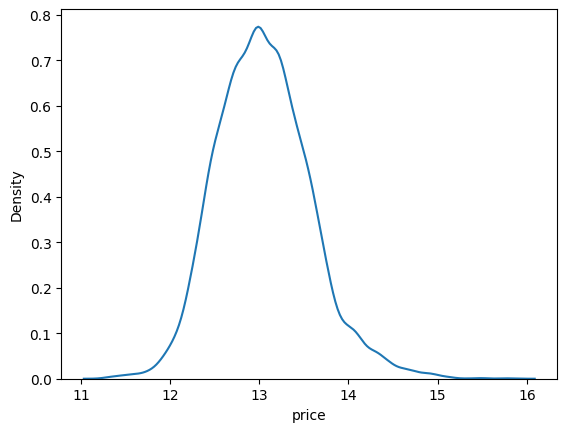

In [10]:
sns.kdeplot(y)
plt.show()

- 피쳐 추가
    - 건축 후 리노베이션까지 걸린 년수
    - 방개수 대비 욕실
    - 거주면적 대비 대지면적
    - 건축된지 몇년 되었는지
- 0으로 나눠져서 NaN이 나오는 케이스 있어서 추가 처리

In [11]:
# 1. 건축 후 리노베이션까지 걸린 년수
train['years_since_renovated'] = train['yr_renovated'] - train['yr_built']
train['years_since_renovated'] = train['years_since_renovated'].apply(lambda x: x if x > 0 else 0)
test['years_since_renovated'] = test['yr_renovated'] - test['yr_built']
test['years_since_renovated'] = test['years_since_renovated'].apply(lambda x: x if x > 0 else 0)

# 2. 방 개수 대비 욕실 개수
train['bath_per_bed'] = train['bathrooms'] / train['bedrooms']
test['bath_per_bed'] = test['bathrooms'] / test['bedrooms']

# 0으로 나누는 경우 NaN을 0으로 대체
train['bath_per_bed'] = train['bath_per_bed'].replace([np.inf, -np.inf, np.nan], 0)
test['bath_per_bed'] = test['bath_per_bed'].replace([np.inf, -np.inf, np.nan], 0)

# 3. 거주면적 대비 대지면적
train['living_per_lot'] = train['sqft_living'] / train['sqft_lot']
test['living_per_lot'] = test['sqft_living'] / test['sqft_lot']

train['living_per_lot'] = train['living_per_lot'].replace([np.inf, -np.inf, np.nan], 0)
test['living_per_lot'] = test['living_per_lot'].replace([np.inf, -np.inf, np.nan], 0)

# 4. 건축된지 몇 년 되었는지
train['age'] = 2025 - train['yr_built']
test['age'] = 2025 - test['yr_built']

# 5. 전체 면적
train['total_sqft'] = train['sqft_living'] + train['sqft_basement']
test['total_sqft'] = test['sqft_living'] + test['sqft_basement']

# 6. 층당 면적
train['sqft_per_floor'] = train['sqft_living'] / train['floors']
test['sqft_per_floor'] = test['sqft_living'] / test['floors']
train['sqft_per_floor'] = train['sqft_per_floor'].replace([np.inf, -np.inf, np.nan], 0)
test['sqft_per_floor'] = test['sqft_per_floor'].replace([np.inf, -np.inf, np.nan], 0)

# 7. 주요 피처 간 상호작용
train['grade_sqft_living'] = train['grade'] * train['sqft_living']
test['grade_sqft_living'] = test['grade'] * test['sqft_living']

train['grade_age'] = train['grade'] * train['age']
test['grade_age'] = test['grade'] * test['age']

train['year_grade'] = train['year'] * train['grade']
test['year_grade'] = test['year'] * test['grade']

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15034 entries, 0 to 15033
Columns: 102 entries, bedrooms to year_grade
dtypes: bool(70), float64(18), int32(1), int64(13)
memory usage: 4.6 MB


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [14]:
# def robust_scale(df):
#     robustscaler = RobustScaler()
#     robustscaler.fit(df)
# 
#     df = robustscaler.transform(df) 
#     return df

In [15]:
df = pd.concat((train, test), axis=0)

print('train shape:', train.shape)
print('test shape:', test.shape)
print('df shape:', df.shape)

train shape: (15034, 102)
test shape: (6468, 103)
df shape: (21502, 103)


In [16]:
# # robust cale로 스케일링
# robust_scale(df)

In [17]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

random_state=2025

gboost = GradientBoostingRegressor(n_estimators=150, max_depth=3, learning_rate=0.1, random_state=random_state)
xgboost = XGBRegressor(n_estimators=150, max_depth=5, learning_rate=0.1, random_state=random_state)
lightgbm = lgb.LGBMRegressor(max_depth=7, n_estimators=200, learning_rate=0.05, random_state=random_state)

estimators = [
    ('gb', gboost),
    ('xgb', xgboost),
    ('lgbm', lightgbm)
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

In [18]:
def AveragingBlending(models, x, y, test):
    for m in models : 
        m['model'].fit(x, y)
    
    predictions = np.column_stack([
        m['model'].predict(test) for m in models
    ])
    return np.mean(predictions, axis=1)

In [19]:
print('--- Stacking Ensemble ---')
if 'price' in test.columns:
    test = test.drop('price', axis=1)

stacking_model.fit(train, y)
y_pred = stacking_model.predict(test)

--- Stacking Ensemble ---


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4169
[LightGBM] [Info] Number of data points in the train set: 12027, number of used features: 102
[LightGBM] [Info] Start training from score 13.051673
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4140
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 102
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002859 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [20]:
def save_submission(prediction, model_name):
    prediction = np.expm1(prediction)
    data_dir = 'data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}.csv'.format('data', model_name)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [21]:
save_submission(y_pred, 'ensemble')

data/submission_ensemble.csv saved!


### 오늘의 회고

- ![kaggle_score](./data/kaggle_score.png)
- 중간에 이상한데 꽂혀서 전처리 하다가 kaggle 점수가 높아진거 보고 잘한줄 착각...
- 앙상블이랑, 하이퍼파라미터 값 찾는거에대한 학습에 의의를 둬야겠다.
- 좀만 더하면 110000이하로 내려갈 것 같은데 계속 그 언저리에서 왔다리 갔다리 한다.
- 오늘은 여기깢...